# Can diapycnal mixing close the transport budget?

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import matplotlib.path as mpath

import cf_xarray
from metpy.interpolate import cross_section
import pyproj
from skimage.filters import gaussian

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cmocean
import matplotlib.colors as col
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator
import calendar

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [ ]:
client = Client()
client

## Load data

In [ ]:
path_output = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'
path_Plots = '/g/data/e14/cs6673/mom6_comparison/Plots_DSW/'
session = cc.database.create_session()

In [ ]:
exptdict = OrderedDict([
    ('panan_01deg', # 1/10th panantarctic zstar run
     {'expt': 'panant-01-zstar-ACCESSyr2',
      'expt_name': 'panan_01deg_jra55_ryf',
      'expt_str': '1/10°'}),
    ('panan_005deg', # 1/20th panantarctic zstar run
     {'expt': 'panant-005-zstar-ACCESSyr2',
      'expt_name': 'panan_005deg_jra55_ryf',
      'expt_str': '1/20°'}),
    ('panan_0025deg', # 1/40th panantarctic zstar run
     {'expt': 'panant-0025-zstar-ACCESSyr2',
      'expt_name': 'panan_0025deg_jra55_ryf',
      'expt_str': '1/40°'})
])

In [ ]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'lon_iso_min': [-62.75, 51.75, -237.15, -191.45],
    'lon_iso_max': [-33.15, 69.3, -218, -172.45],
    'sector': [[-65, -22, -78, -55], [45, 75, -69, -63],
               [100-360, 155-360, -69, -60], [165-360, -170, -77, -68]],
    'section_name': [
        ['Peninsula'], ['57°E', 'Wild Canyon'], ['125°E', '140°E'],
        ['Drygalski Trough', 'Joides Trough', 'Glomar Challenger Trough']],
    'section_shelf_lat': [
        [-64.5], [-66.5, -67.5], [-66, -66], [-72.2, -73.5, -76]],
    'section_shelf_lon': [
        [-55], [57.6, 68], [-235, -220], [-187.8, -183.5, -178.3]],
    'section_abyss_lat': [
        [-61.5], [-64.5, -65], [-60, -60], [-68.2, -69.5, -73]],
    'section_abyss_lon': [
        [-35], [56.9, 66], [-235, -220], [-190.9, -181.6, -173.1]],
    'section_indices':[[0], [0], [0], [150, 150]],
    'lon_min_area': [-58, 47, 90-360, 166-360],
    'lon_max_area': [-30, 72, 147-360, -170],
    'lat_min_area': [-75, -68, -67.5, -76.5],
    'lat_max_area': [-59, -64, -61.9, -65.8]}

In [ ]:
def shelf_mask_isobath(var, contour_depth, resolution, output_mask=False):
    '''
    Masks varibales by the region polewards of a given isobath
    '''
    
    ds_contour = xr.open_dataset(
        '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
        'Antarctic_slope_contour_' + str(contour_depth) + 'm_MOM6_' +
        resolution + 'deg.nc')
    
    shelf_mask = ds_contour.contour_masked_above.sel(yh=slice(var.yh[0], var.yh[-1]))
    yh = ds_contour.yh.sel(yh=slice(var.yh[0], var.yh[-1]))
    xh = ds_contour.xh
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask = shelf_mask.where(shelf_mask == 0)+1
    shelf_mask = shelf_mask.where(shelf_mask == 1, 0)
    
    # multiply the variable with the mask
    masked_var = var * shelf_mask
    
    if output_mask == True:
        return masked_var, shelf_mask
    else:
        return masked_var

In [ ]:
def yearly_mean(var):
    # construct an xarray of days per month
    month_length = var.time.dt.days_in_month
    weights_month = (month_length.groupby('time.year') /
                     month_length.groupby('time.year').sum())
    var = (var * weights_month).groupby('time.year').sum()
    var = var.rename({'year': 'time'})
    var = var.where(var != 0)
    return var

In [ ]:
%%time
ekeys = ['panan_01deg', 'panan_005deg']
start_time = '2004-01-01'
end_time = '2004-12-31'

for ekey in ekeys:
    print(ekey)
    e = exptdict[ekey]
    resolution = e['expt'].split('-')[1]

    # reference density in MOM6 
    rho_0 = 1035.0

    for a, area_text in enumerate(DSW_region['name']):
        ds_D_m = xr.open_dataset(
            path_output + 'Diapycnal_transport_at_upper_interface_' +
            'in_' + area_text + '_' + e['expt_name'] + '_1m_' +
            start_time[:4] + '.nc', chunks='auto')
        # ds_D = yearly_mean(ds_D_m).squeeze().drop('time')
        ds_D = ds_D_m
        e['D_' + area_text[0]] = (
            ds_D.diapycnal_transport/rho_0/1e6).compute()  # in Sv

        # UMO and VMO
        U = cc.querying.getvar(
            e['expt'], 'umo', session, frequency='1 monthly',
            start_time=start_time, end_time=end_time,
            chunks={'rho2_l': '200MB'}).sel(
            time=slice(start_time, end_time),
            xq=slice(DSW_region['lon_min_area'][a],
                     DSW_region['lon_max_area'][a]),
            yh=slice(DSW_region['lat_min_area'][a],
                     DSW_region['lat_max_area'][a]))
        # U = yearly_mean(U).squeeze()
        e['U_' + area_text[0]] = (U/rho_0/1e6).compute()  # in Sv
        V = cc.querying.getvar(
            e['expt'], 'vmo', session, frequency='1 monthly',
            start_time=start_time, end_time=end_time,
            chunks={'rho2_l': '200MB'}).sel(
            time=slice(start_time, end_time),
            xh=slice(DSW_region['lon_min_area'][a],
                     DSW_region['lon_max_area'][a]),
            yq=slice(DSW_region['lat_min_area'][a],
                     DSW_region['lat_max_area'][a]))
        # V = yearly_mean(V).squeeze()
        e['V_' + area_text[0]] = (V/rho_0/1e6).compute()  # in Sv

        e['vol_' + area_text[0]] = cc.querying.getvar(
            e['expt'], 'volcello', session,
            attrs={'cell_methods': 'area:sum rho2_l:sum yh:sum xh:sum time: point'},
            start_time=start_time, end_time=str(np.int(start_time[:4])+1) + '-01-31',
            chunks={'rho2_l': '200MB'}).sel(
            time=slice(start_time,  str(np.int(start_time[:4])+1) + '-01-31'),
            xh=slice(DSW_region['lon_min_area'][a],
                     DSW_region['lon_max_area'][a]),
            yh=slice(DSW_region['lat_min_area'][a],
                     DSW_region['lat_max_area'][a])).squeeze()

    e['depth'] = cc.querying.getvar(
        e['expt'], 'deptho', session, n=1,
        chunks={'xh': '400MB', 'yh': '400MB'}).sel(
        yh=slice(None, -55))

    for contour_depth in [650, 2500]:
        ds_transp = xr.open_dataset(
            path_output + 'vol_transp_across_' + str(contour_depth) +
            'm_isobath_' + e['expt_name'] + '_1m_' + start_time[:4] + '.nc')
        e['transp' + str(contour_depth) + 'm'] = (
            ds_transp.vol_trans_across_contour.assign_coords(
                {'lon': ds_transp.lon, 'lat': ds_transp.lat}))
        # e['transp' + str(contour_depth) + 'm'] = yearly_mean(
        #     e['transp' + str(contour_depth) + 'm']).squeeze().compute()

        e['mask_' + str(contour_depth) + 'm'] = xr.open_dataset(
            path_output + '/../Antarctic_slope_contours/Antarctic_slope_contour_' +
            str(contour_depth) + 'm_MOM6_' + resolution + 'deg.nc').contour_masked_above

In [41]:
def transport_budget(ekey, area):
    e = exptdict[ekey]
    resolution = e['expt'].split('-')[1]
    a = DSW_region['name'].index(area)
    area_letter = area[0]
    sig = [37.17, 37.14, 37.14, 37.16]
    sig = sig[a]
    
    var = e['D_' + area_letter]
    U = e['U_' + area_letter].sel(rho2_l=slice(sig+1000, None))
    V = e['V_' + area_letter].sel(rho2_l=slice(sig+1000, None))
    vol = e['vol_' + area_letter]
    
    if area == 'Weddell':
        lon_range = [-58, -48]
        lat_range =[-70, -62.2]
    if area == 'Prydz':
        lon_range = [57, 71]
        lat_range =[-70, -62.5]
    elif area == 'Adelie':
        lon_range = [-236.5, -216]
        lat_range =[-70, -62.5]
    elif area == 'Ross':
        lon_range = [-193, -172.5]
        lat_range =[-77, -68]
    lon_min = lon_range[0]
    lon_max = lon_range[1]
    lat_min = lat_range[0]
    lat_max = lat_range[1]
    
    iso650 = e['transp650m'].compute()
    iso650 = iso650.where((iso650.lon >= lon_min) &  
                          (iso650.lon <= lon_max) &
                          (iso650.lat >= lat_min) &  
                          (iso650.lat <= lat_max), drop=True)
    iso650 = iso650.sel(rho2_l=slice(sig+1000, None))
    
    iso2500 = e['transp2500m'].compute()
    iso2500 = iso2500.where((iso2500.lon >= lon_min) &  
                            (iso2500.lon <= lon_max) &
                            (iso2500.lat >= lat_min) &  
                            (iso2500.lat <= lat_max), drop=True)
    iso2500 = iso2500.sel(rho2_l=slice(sig+1000, None))

    if area == 'Weddell':
        # first lat value needs to be on the yh grid and the maximum
        while ((U.yh == iso650.lat[0].values).sum() == 0) or (
            iso650.lat.argmax().values != 0):
            iso650 = iso650.isel(contour_index=slice(1, None))
        while ((U.yh == iso2500.lat[0].values).sum() == 0) or (
            iso2500.lat.argmax().values != 0):
            iso2500 = iso2500.isel(contour_index=slice(1, None))
        # last lat value needs to be on the yh grid and the minimum
        while ((U.yh == iso650.lat[-1].values).sum() == 0) or (
            iso650.lat.argmin().values+1 == len(iso650.lat)):
            iso650 = iso650.isel(contour_index=slice(0, -1))
        while ((U.yh == iso2500.lat[-1].values).sum() == 0) or (
            iso2500.lat.argmin().values+1 != len(iso2500.lat)):
            iso2500 = iso2500.isel(contour_index=slice(0, -1))
        # crop to same minimum and maximum
        iso_min = np.round(np.max((iso650.lat.min(), iso2500.lat.min())), 3)
        iso2500 = iso2500.where(np.round(iso2500.lat, 3) >= iso_min, drop=True)
        iso650 = iso650.where(np.round(iso650.lat, 3) >= iso_min, drop=True)
        iso_max = np.round(np.min((iso650.lat.max(), iso2500.lat.max())), 3)
        iso2500 = iso2500.where(np.round(iso2500.lat, 3) <= iso_max, drop=True)
        iso650 = iso650.where(np.round(iso650.lat, 3) <= iso_max, drop=True)
        # for whatever reason minimum of iso650 is smaller than iso2500
        # and not the last index, therefore I drop that min value
        if (iso650.lat.min() < iso2500.lat.min()) & (
            iso650.lat.argmin()+1 != len(iso650.lat)):
            iso650 = iso650.where(iso650.lat != iso650.lat.min(), drop=True)
    
        offset_xh = (V.xh.diff('xh')[0]/2)
        offset_yq = V.sel(yq=slice(iso650.lat[-1]-.5, iso650.lat[-1]+.5)).yq.diff('yq').mean()/2
        V_min = V.sel(yq=iso650.lat[-1].values-offset_yq, method='nearest').sel(
             xh=slice(iso650.lon[-1], iso2500.lon[-1]))
        assert np.fabs(V_min.yq + offset_yq.values - iso650.lat[-1]) < 1e-10, (
            'lat of V_min not correct')
        assert np.round((V_min.xh[0] - iso650.lon[-1]).values, 3) == np.float(
            '0.' + resolution[1:])/2, (
            'lon of V_min at 650m isobath not correct')
        assert np.round((iso2500.lon[-1] - V_min.xh[-1]).values, 3) == np.float(
            '0.' + resolution[1:])/2, (
            'lon of V_min at 2500m isobath not correct')
    
        offset_xh = (V.xh.diff('xh')[0]/2)
        offset_yq = V.sel(yq=slice(iso650.lat[0]-.5, iso650.lat[0]+.5)).yq.diff('yq').mean()/2
        V_max = V.sel(yq=iso650.lat[0].values+offset_yq, method='nearest').sel(
             xh=slice(iso650.lon[0], iso2500.lon[0]))
        assert np.fabs(V_max.yq - offset_yq.values - iso650.lat[0]) < 1e-4, (
            'lat of V_max not correct')
        assert  np.round((V_max.xh[0] - iso650.lon[0]).values, 3) == np.float(
            '0.' + resolution[1:])/2, (
            'lon of V_max at 650m isobath not correct')
        assert np.round((iso2500.lon[0] - V_max.xh[-1]).values, 3) == np.float(
            '0.' + resolution[1:])/2, (
            'lon of V_max at 2500m isobath not correct')
    
    else:
        
        # first lon value needs to be on the xh grid and the minimum
        while ((V.xh == iso650.lon[0].values).sum() == 0) or (
            iso650.lon.argmin().values != 0):
            iso650 = iso650.isel(contour_index=slice(1, None))
        while ((V.xh == iso2500.lon[0].values).sum() == 0) or (
            iso2500.lon.argmin().values != 0):
            iso2500 = iso2500.isel(contour_index=slice(1, None))
        # last lon value needs to be on the xh grid and the maximum
        while ((V.xh == iso650.lon[-1].values).sum() == 0) or (
            iso650.lon.argmax().values+1 != len(iso650.lon)):
            iso650 = iso650.isel(contour_index=slice(0, -1))
        while ((V.xh == iso2500.lon[-1].values).sum() == 0) or (
            iso2500.lon.argmax().values+1 != len(iso2500.lon)):
            iso2500 = iso2500.isel(contour_index=slice(0, -1))
        # crop to same minimum and maximum
        iso_min = np.round(np.max((iso650.lon.min(), iso2500.lon.min())), 3)
        iso2500 = iso2500.where(np.round(iso2500.lon, 3) >= iso_min, drop=True)
        iso650 = iso650.where(np.round(iso650.lon, 3) >= iso_min, drop=True)
        iso_max = np.round(np.min((iso650.lon.max(), iso2500.lon.max())), 3)
        iso2500 = iso2500.where(np.round(iso2500.lon, 3) <= iso_max, drop=True)
        iso650 = iso650.where(np.round(iso650.lon, 3) <= iso_max, drop=True)
        
        offset_xq = (U.xq.diff('xq')[0]/2)
        offset_yh = U.sel(yh=slice(iso650.lat[0]-.5, iso650.lat[0]+.5)).yh.diff('yh').mean()/2
        U_min = U.sel(xq=iso650.lon[0].values-offset_xq, method='nearest').sel(
             yh=slice(iso650.lat[0], iso2500.lat[0]))
        assert np.round((U_min.xq - iso650.lon[0]).values, 3) == -np.float('0.' + resolution[1:])/2, (
            'lon of U_min not correct')
        assert np.fabs(((U_min.yh[0] - iso650.lat[0]) - U_min.yh[:2].diff('yh')/2).values) < 1e-10, (
            'lat of U_min at 650m isobath not correct')
        assert np.fabs((iso2500.lat[0] - (U_min.yh[-1]) - U_min.yh[-2:].diff('yh')/2).values) < 1e-10, (
            'lat of U_min at 2500m isobath not correct')
        
        offset_xq = (U.xq.diff('xq')[-1]/2)
        offset_yh = U.sel(yh=slice(iso650.lat[-1]-.5, iso650.lat[-1]+.5)).yh.diff('yh').mean()/2
        U_max = U.sel(xq=iso650.lon[-1].values+offset_xq, method='nearest').sel(
             yh=slice(iso650.lat[-1]+offset_yh, iso2500.lat[-1]))
        assert np.round((iso650.lon[-1] - U_max.xq).values, 3) == -np.float('0.' + resolution[1:])/2, (
            'lon of U_max not correct')
        assert np.fabs(((U_max.yh[0] - iso650.lat[-1]) - U_max.yh[:2].diff('yh')/2).values) < 1e-10, (
            'lat of U_max at 650m isobath not correct')
        assert np.fabs((iso2500.lat[-1] - (U_max.yh[-1]) - U_max.yh[-2:].diff('yh')/2).values) < 1e-10, (
            'lat of U_max at 2500m isobath not correct')
    
    mask_shelf = e['mask_650m']*0+1
    mask_shelf = (mask_shelf.where(e['mask_650m'] > 0, 0) +
                  mask_shelf.where((e['mask_650m'] == -1000) & (e['mask_2500m'] == 0), 0))
    if area == 'Weddell':
        mask_shelf = mask_shelf.where(mask_shelf.yh > V_min.yq.values)
        mask_shelf = mask_shelf.where(mask_shelf.yh < V_max.yq.values)
        mask_shelf = mask_shelf.where(
            (mask_shelf.xh > np.min((iso650.lon.min(), iso2500.lon.min()))-.1) &
            (mask_shelf.xh < np.max((iso650.lon.max(), iso2500.lon.max()))+.1))
        # to mask area in top left corner, on the other side of peninsula
        mask_shelf = mask_shelf.where(
            (mask_shelf + (mask_shelf.where(
                (mask_shelf.xh < -55.5) & (mask_shelf.yh > -63), 0)-1)) == 0)
    else:
        mask_shelf = mask_shelf.where(mask_shelf.xh > U_min.xq.values)
        mask_shelf = mask_shelf.where(mask_shelf.xh < U_max.xq.values)
        mask_shelf = mask_shelf.where(mask_shelf == 1)
    
    D_masked = var.sel(rho2_l=sig+1000, method='nearest')
    D_masked = D_masked.where(mask_shelf == 1)
    
    vol_masked = vol.sel(rho2_l=slice(sig+1000, None))
    vol_masked = vol_masked.where(mask_shelf == 1)
    
    dvol = (vol_masked.sum(['rho2_l', 'xh', 'yh']).diff('time')/(vol_masked.time.diff(
        'time').astype('int')/1e9))/1e6
    dvol['time'] = D_masked.time
    
    plt.figure(figsize=(10, 4))

    if area == 'Weddell':
        plt.plot(V_min.sum(['rho2_l', 'xh']), label='V south', color='c')
        plt.plot(V_max.sum(['rho2_l', 'xh']), label='V north', color='tab:blue')
    else:
        plt.plot(U_min.sum(['rho2_l', 'yh']), label='U west', color='c')
        plt.plot(U_max.sum(['rho2_l', 'yh']), label='U east', color='tab:blue')
    
    plt.plot(iso650.sum(['rho2_l', 'contour_index']), label='V at 650m', color='tab:orange')
    plt.plot(iso2500.sum(['rho2_l', 'contour_index']), label='V at 2500m', color='r')

    if area == 'Weddell':
        D_residual = (iso650.sum(['rho2_l', 'contour_index']).values
                      - iso2500.sum(['rho2_l', 'contour_index']).values
                      + V_min.sum(['rho2_l', 'xh'])
                      - V_max.sum(['rho2_l', 'xh'])
                      - dvol)
    else:
        D_residual = (iso650.sum(['rho2_l', 'contour_index']).values
                      - iso2500.sum(['rho2_l', 'contour_index']).values
                      + U_min.sum(['rho2_l', 'yh'])
                      - U_max.sum(['rho2_l', 'yh'])
                      - dvol)
    
    plt.plot(D_residual, color='k',
             label='Transport across upper isopycnal (residual)')
    plt.plot(D_masked.sum(['xh', 'yh']), linestyle='--', color='y',
             label='Transport across upper isopycnal')
    
    plt.plot(dvol, label='$\Delta$Volume/$\Delta$t', color='tab:green')
    
    plt.axhline(0, color='grey', linestyle='--')
    
    ax = plt.gca()
    ax.set_xticks(np.arange(12), calendar.month_abbr[1:])
    plt.autoscale(enable=True, axis='x', tight=True)
    
    plt.ylabel('Transport (Sv)')
    plt.title(DSW_region['name_long'][a] + ' in ' + e['expt_str'],
              fontweight='bold', y=1.22)
    plt.legend(ncol=4, loc='center', bbox_to_anchor=(.45, 1.12))
    
    plt.show()
    
    
    plt.figure(figsize=(10, 4))

    if area == 'Weddell':
        txt = str(np.round(yearly_mean(
            V_max.sum(['rho2_l', 'xh']) - V_min.sum(['rho2_l', 'xh']))[0].values, 3))
        plt.plot(V_max.sum(['rho2_l', 'xh']) - V_min.sum(['rho2_l', 'xh']),
             label='meridional advection (north - south): ' + txt + ' Sv',
                 color='tab:blue')
    else:
        txt = str(np.round(yearly_mean(
            U_max.sum(['rho2_l', 'yh']) - U_min.sum(['rho2_l', 'yh']))[0].values, 3))
        plt.plot(U_max.sum(['rho2_l', 'yh']) - U_min.sum(['rho2_l', 'yh']),
                 label='zonal advection (east - west): ' + txt + ' Sv',
                 color='tab:blue')
    txt = str(np.round(yearly_mean(
        iso2500.sum(['rho2_l', 'contour_index']) -
        iso650.sum(['rho2_l', 'contour_index']))[0].values, 3))
    plt.plot(iso2500.sum(['rho2_l', 'contour_index']) -
             iso650.sum(['rho2_l', 'contour_index']),
             label='transport diff. across isobaths (2500m - 650m): ' +
             txt + ' Sv', color='tab:orange')
    txt = str(np.round(yearly_mean(
        D_masked.sum(['xh', 'yh']))[0].values, 3))
    plt.plot(D_masked.sum(['xh', 'yh']), color='k',
             label='Transport across upper isopycnal: ' + txt + ' Sv')
    txt = str(np.round(yearly_mean(dvol)[0].values, 3))
    plt.plot(dvol, label='$\Delta$Volume/$\Delta$t: ' + txt + ' Sv',
             color='tab:green')
    
    plt.axhline(0, color='grey', linestyle='--')
    
    ax = plt.gca()
    ax.set_xticks(np.arange(12), calendar.month_abbr[1:])
    plt.autoscale(enable=True, axis='x', tight=True)
    
    plt.ylabel('Transport (Sv)')
    plt.title(DSW_region['name_long'][a] + ' in ' + e['expt_str'],
              fontweight='bold', y=1.22)
    plt.legend(ncol=2, loc='center', bbox_to_anchor=(.45, 1.12))
    
    plt.show()

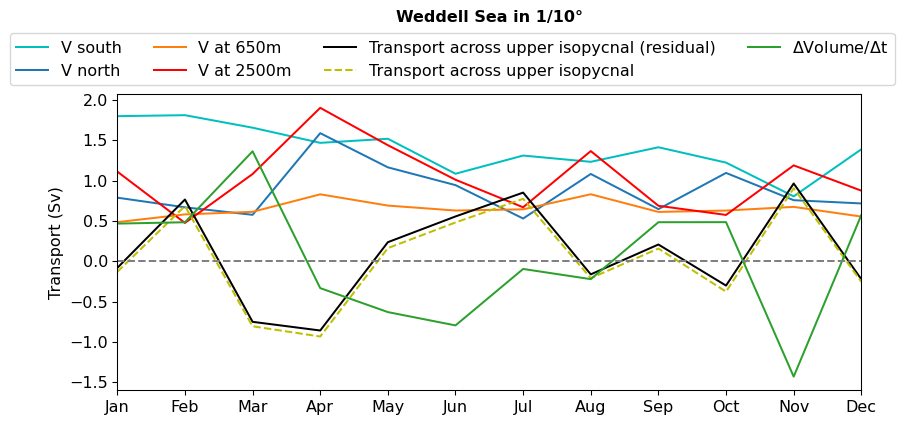

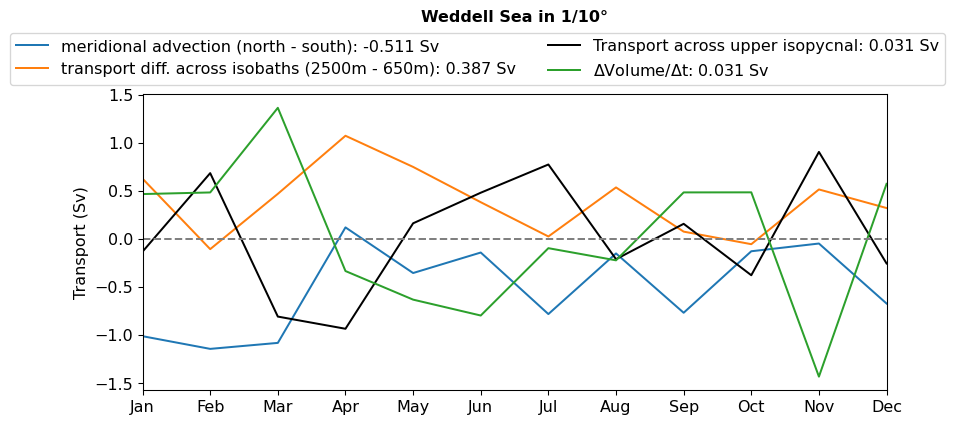

In [42]:
ekey = 'panan_01deg'
area = 'Weddell'
transport_budget(ekey, area)

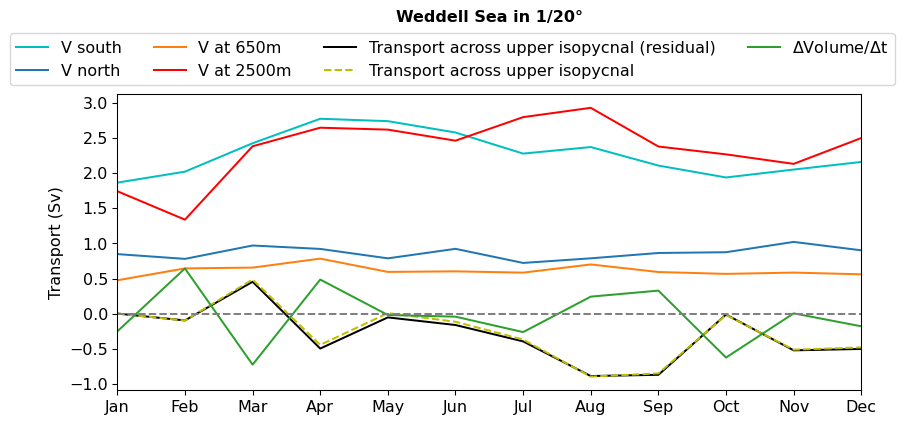

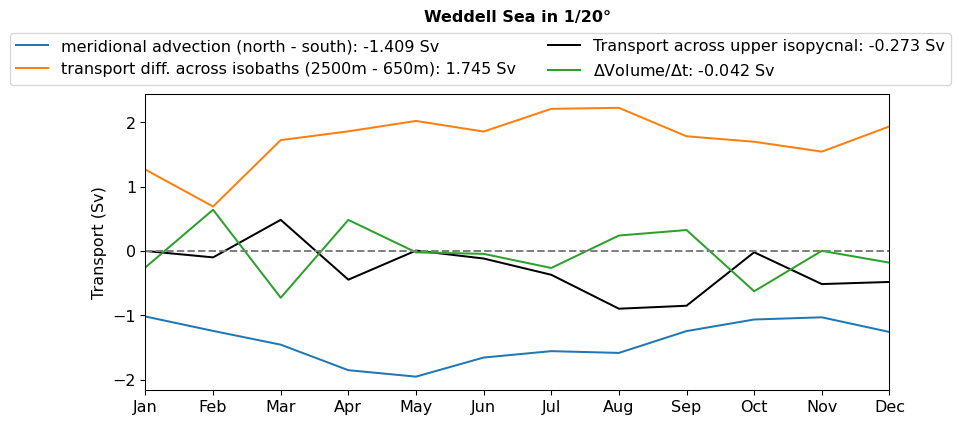

In [43]:
ekey = 'panan_005deg'
area = 'Weddell'
transport_budget(ekey, area)

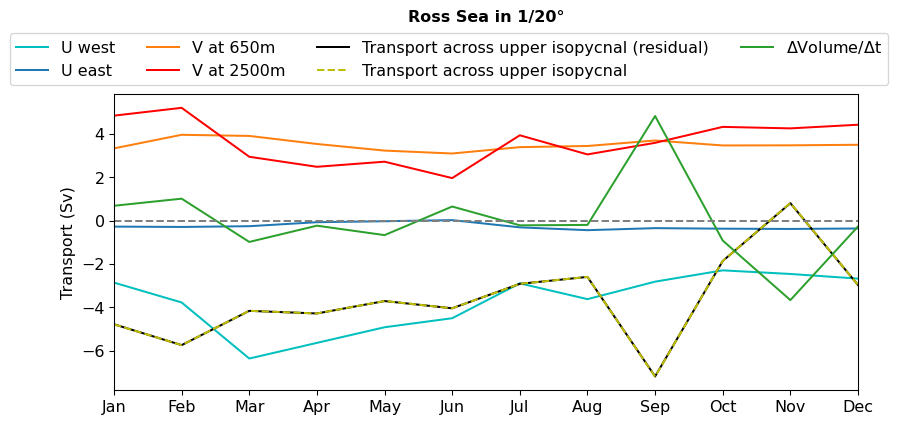

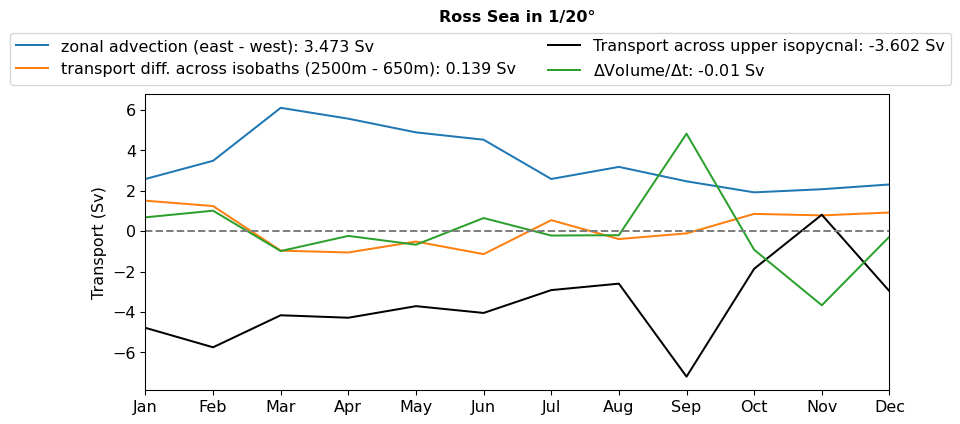

In [44]:
ekey = 'panan_005deg'
area = 'Ross'
transport_budget(ekey, area)

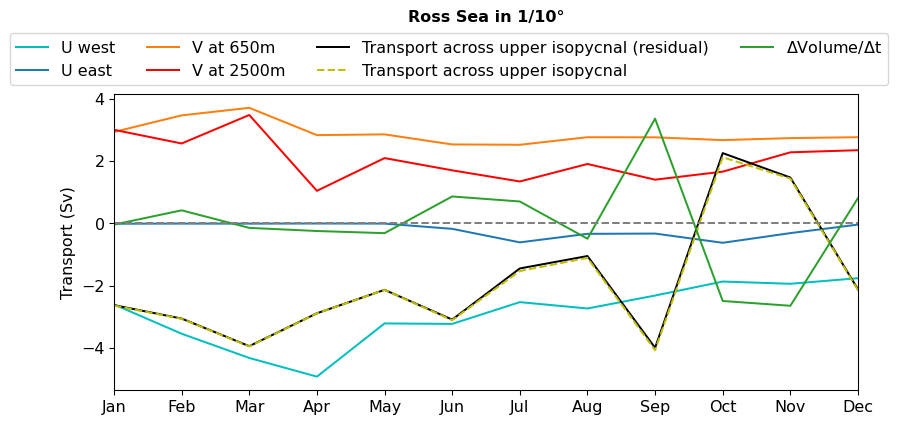

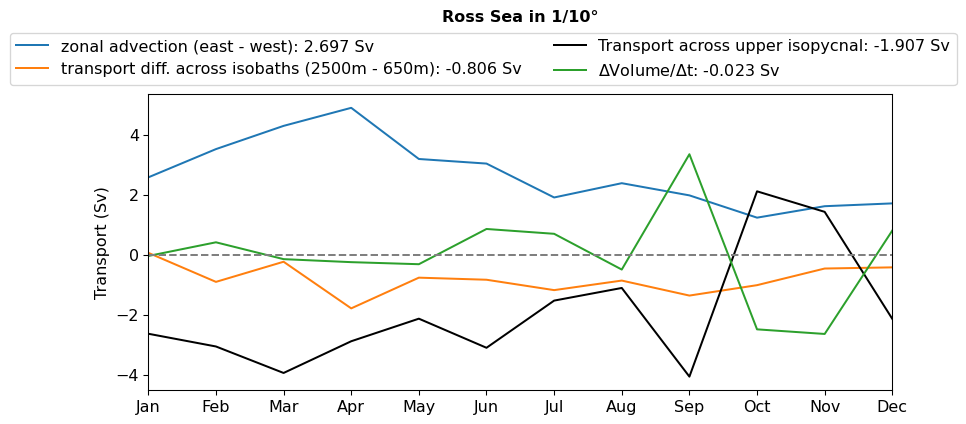

In [45]:
ekey = 'panan_01deg'
area = 'Ross'
transport_budget(ekey, area)

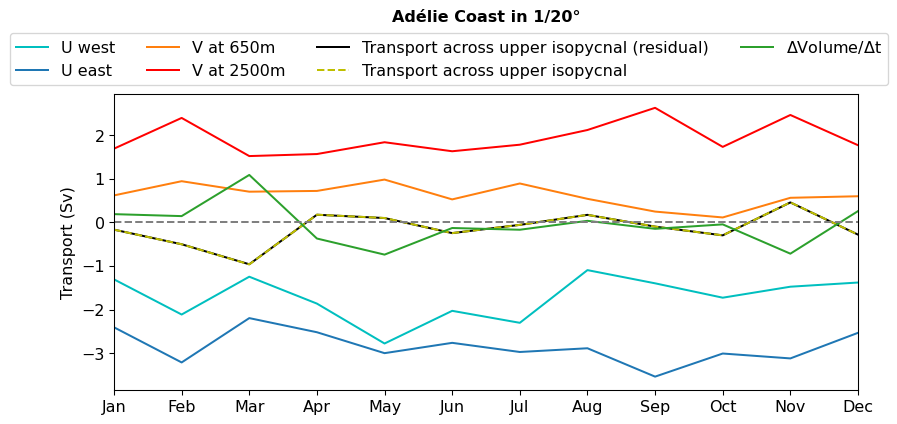

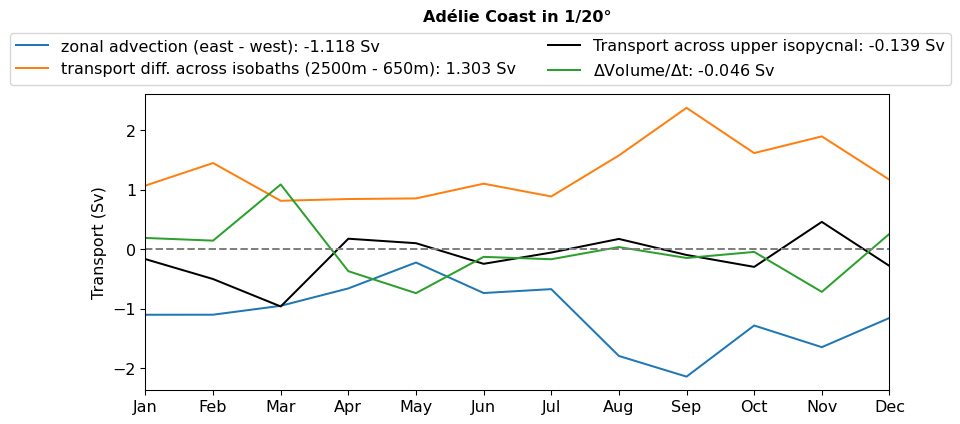

In [46]:
ekey = 'panan_005deg'
area = 'Adelie'
transport_budget(ekey, area)

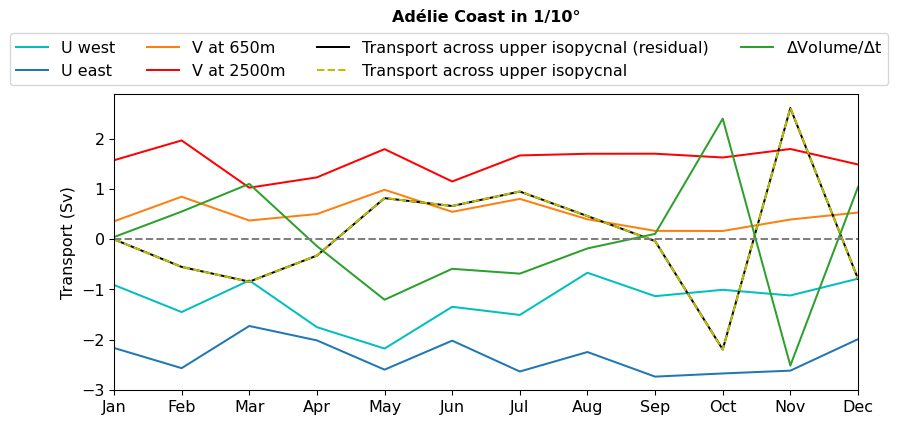

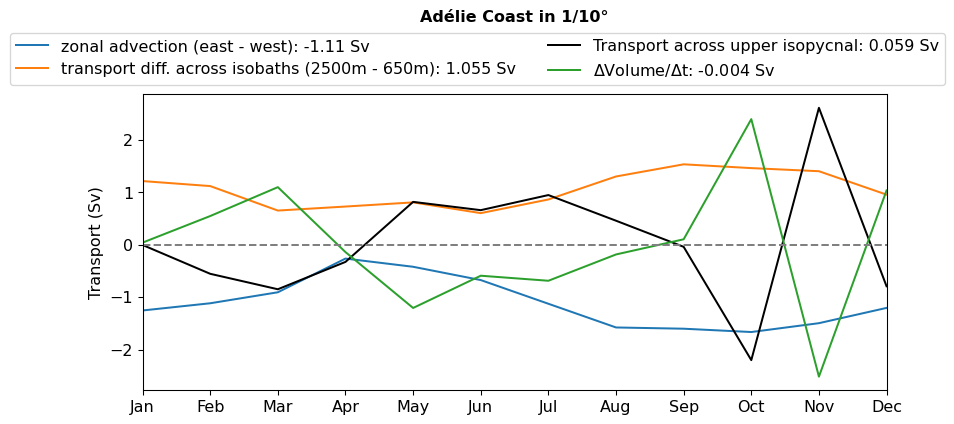

In [47]:
ekey = 'panan_01deg'
area = 'Adelie'
transport_budget(ekey, area)

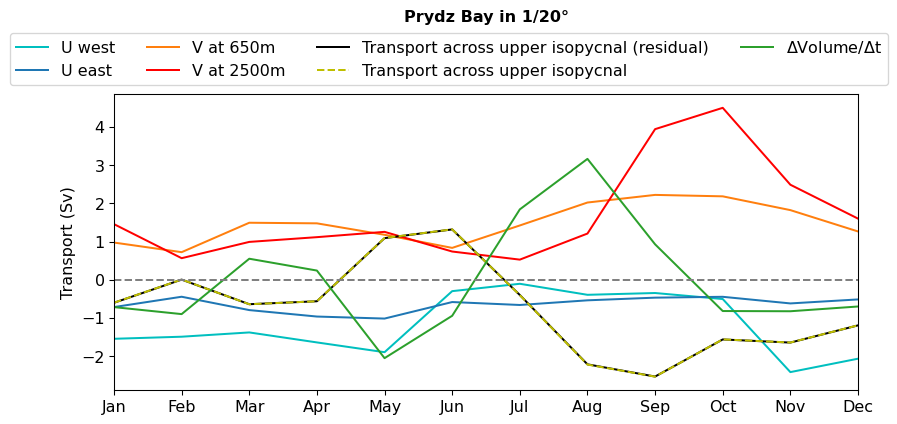

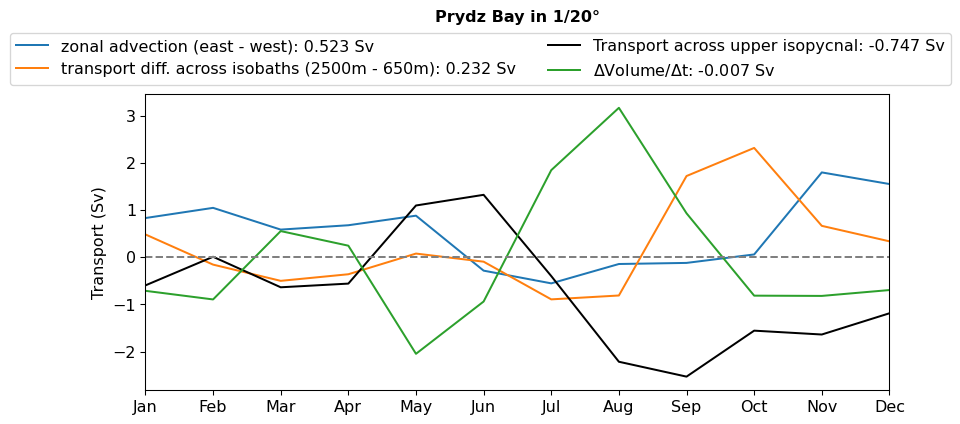

In [48]:
ekey = 'panan_005deg'
area = 'Prydz'
transport_budget(ekey, area)

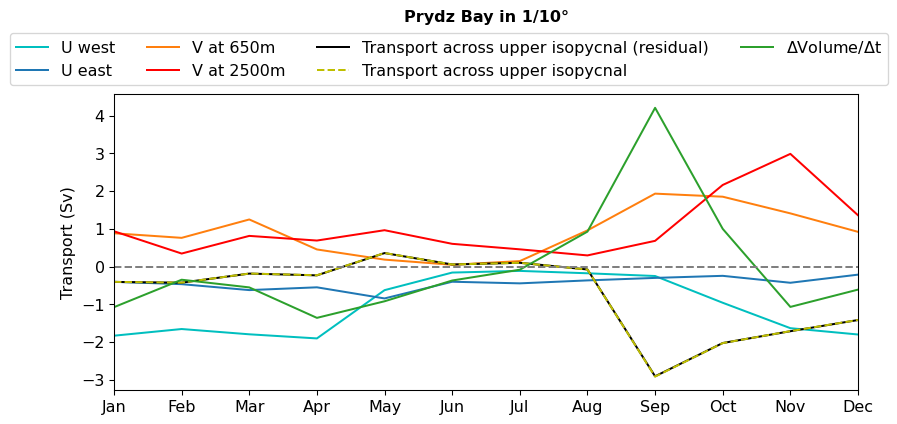

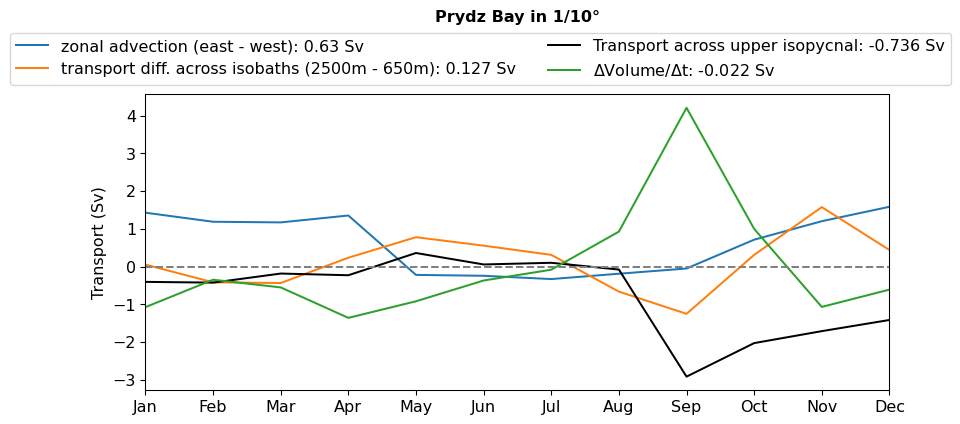

In [49]:
ekey = 'panan_01deg'
area = 'Prydz'
transport_budget(ekey, area)

### To check mask is enclosed by sections and isobaths and everything is on the correct grid

Need to run cell below for model resolution and are required, then choose cell below with xlim and ylim corresponding to region

In [315]:
e = exptdict['panan_01deg']
resolution = e['expt'].split('-')[1]
area = 'Adelie'
a = DSW_region['name'].index(area)
area_letter = area[0]
sig = [37.17, 37.14, 37.14, 37.16]
sig = sig[a]

var = e['D_' + area_letter][0, :]
U = e['U_' + area_letter][0, :].sel(rho2_l=slice(sig+1000, None))
V = e['V_' + area_letter][0, :].sel(rho2_l=slice(sig+1000, None))
vol = e['vol_' + area_letter]


if area == 'Weddell':
    lon_range = [-58, -48]
    lat_range =[-70, -62.2]
if area == 'Prydz':
    lon_range =[57, 71]
    lat_range =[-70, -62.5]
elif area == 'Adelie':
    lon_range =[-236.5, -216]
    lat_range =[-70, -62.5]
elif area == 'Ross':
    lon_range = [-193, -172.5]
    lat_range =[-77, -68]
lon_min = lon_range[0]
lon_max = lon_range[1]
lat_min = lat_range[0]
lat_max = lat_range[1]
# iso650 = yearly_mean(e['transp650m']).squeeze().compute()
iso650 = e['transp650m'][0, :]
iso650 = iso650.where((iso650.lon >= lon_min) &  
                      (iso650.lon <= lon_max) &
                      (iso650.lat >= lat_min) &  
                      (iso650.lat <= lat_max), drop=True)
if (area == 'Weddell') & (
    np.fabs(iso650.lon.diff('contour_index').max()) > .1):
    iso650 = iso650.isel(contour_index=slice(
        iso650.lon.diff('contour_index').argmax().values+1, None))
iso650 = iso650.sel(rho2_l=slice(sig+1000, None))
# iso2500 = yearly_mean(e['transp2500m']).squeeze().compute()
iso2500 = e['transp2500m'][0, :]
iso2500 = iso2500.where((iso2500.lon >= lon_min) &  
                        (iso2500.lon <= lon_max) &
                        (iso2500.lat >= lat_min) &  
                        (iso2500.lat <= lat_max), drop=True)
iso2500 = iso2500.sel(rho2_l=slice(sig+1000, None))

if area == 'Weddell':
    # first lat value needs to be on the yh grid and the maximum
    while ((U.yh == iso650.lat[0].values).sum() == 0) or (
        iso650.lat.argmax().values != 0):
        iso650 = iso650.isel(contour_index=slice(1, None))
    while ((U.yh == iso2500.lat[0].values).sum() == 0) or (
        iso2500.lat.argmax().values != 0):
        iso2500 = iso2500.isel(contour_index=slice(1, None))
    # last lat value needs to be on the yh grid and the minimum
    while ((U.yh == iso650.lat[-1].values).sum() == 0) or (
        iso650.lat.argmin().values+1 == len(iso650.lat)):
        iso650 = iso650.isel(contour_index=slice(0, -1))
    while ((U.yh == iso2500.lat[-1].values).sum() == 0) or (
        iso2500.lat.argmin().values+1 != len(iso2500.lat)):
        iso2500 = iso2500.isel(contour_index=slice(0, -1))
    # crop to same minimum and maximum
    iso_min = np.round(np.max((iso650.lat.min(), iso2500.lat.min())), 3)
    iso2500 = iso2500.where(np.round(iso2500.lat, 3) >= iso_min, drop=True)
    iso650 = iso650.where(np.round(iso650.lat, 3) >= iso_min, drop=True)
    iso_max = np.round(np.min((iso650.lat.max(), iso2500.lat.max())), 3)
    iso2500 = iso2500.where(np.round(iso2500.lat, 3) <= iso_max, drop=True)
    iso650 = iso650.where(np.round(iso650.lat, 3) <= iso_max, drop=True)
    # for whatever reason minimum of iso650 is smaller than iso2500
    # and not the last index, therefore I drop that min value
    if (iso650.lat.min() < iso2500.lat.min()) & (
        iso650.lat.argmin()+1 != len(iso650.lat)):
        iso650 = iso650.where(iso650.lat != iso650.lat.min(), drop=True)

    offset_xh = (V.xh.diff('xh')[0]/2)
    offset_yq = V.sel(yq=slice(iso650.lat[-1]-.5, iso650.lat[-1]+.5)).yq.diff('yq').mean()/2
    V_min = V.sel(yq=iso650.lat[-1].values-offset_yq, method='nearest').sel(
         xh=slice(iso650.lon[-1], iso2500.lon[-1]))
    assert np.fabs(V_min.yq + offset_yq.values - iso650.lat[-1]) < 1e-10, (
        'lat of V_min not correct')
    assert np.round((V_min.xh[0] - iso650.lon[-1]).values, 3) == np.float(
        '0.' + resolution[1:])/2, (
        'lon of V_min at 650m isobath not correct')
    assert np.round((iso2500.lon[-1] - V_min.xh[-1]).values, 3) == np.float(
        '0.' + resolution[1:])/2, (
        'lon of V_min at 2500m isobath not correct')

    offset_xh = (V.xh.diff('xh')[0]/2)
    offset_yq = V.sel(yq=slice(iso650.lat[0]-.5, iso650.lat[0]+.5)).yq.diff('yq').mean()/2
    V_max = V.sel(yq=iso650.lat[0].values+offset_yq, method='nearest').sel(
         xh=slice(iso650.lon[0], iso2500.lon[0]))
    assert np.fabs(V_max.yq - offset_yq.values - iso650.lat[0]) < 1e-4, (
        'lat of V_max not correct')
    assert  np.round((V_max.xh[0] - iso650.lon[0]).values, 3) == np.float(
        '0.' + resolution[1:])/2, (
        'lon of V_max at 650m isobath not correct')
    assert np.round((iso2500.lon[0] - V_max.xh[-1]).values, 3) == np.float(
        '0.' + resolution[1:])/2, (
        'lon of V_max at 2500m isobath not correct')
    
else:
    # first lon value needs to be on the xh grid and the minimum
    while ((V.xh == iso650.lon[0].values).sum() == 0) or (
        iso650.lon.argmin().values != 0):
        iso650 = iso650.isel(contour_index=slice(1, None))
    while ((V.xh == iso2500.lon[0].values).sum() == 0) or (
        iso2500.lon.argmin().values != 0):
        iso2500 = iso2500.isel(contour_index=slice(1, None))
    # last lon value needs to be on the xh grid and the maximum
    while ((V.xh == iso650.lon[-1].values).sum() == 0) or (
        iso650.lon.argmax().values+1 != len(iso650.lon)):
        iso650 = iso650.isel(contour_index=slice(0, -1))
    while ((V.xh == iso2500.lon[-1].values).sum() == 0) or (
        iso2500.lon.argmax().values+1 != len(iso2500.lon)):
        iso2500 = iso2500.isel(contour_index=slice(0, -1))
    # crop to same minimum and maximum
    iso_min = np.round(np.max((iso650.lon.min(), iso2500.lon.min())), 3)
    iso2500 = iso2500.where(np.round(iso2500.lon, 3) >= iso_min, drop=True)
    iso650 = iso650.where(np.round(iso650.lon, 3) >= iso_min, drop=True)
    iso_max = np.round(np.min((iso650.lon.max(), iso2500.lon.max())), 3)
    iso2500 = iso2500.where(np.round(iso2500.lon, 3) <= iso_max, drop=True)
    iso650 = iso650.where(np.round(iso650.lon, 3) <= iso_max, drop=True)

    offset_xq = (U.xq.diff('xq')[0]/2)
    U_min = U.sel(xq=iso650.lon[0].values-offset_xq, method='nearest').sel(
         yh=slice(iso650.lat[0], iso2500.lat[0]))
    assert np.round((U_min.xq - iso650.lon[0]).values, 3) == -np.float('0.' + resolution[1:])/2, (
        'lon of U_min not correct')
    assert np.fabs(((U_min.yh[0] - iso650.lat[0]) - U_min.yh[:2].diff('yh')/2).values) < 1e-10, (
        'lat of U_min at 650m isobath not correct')
    assert np.fabs((iso2500.lat[0] - (U_min.yh[-1]) - U_min.yh[-2:].diff('yh')/2).values) < 1e-10, (
        'lat of U_min at 2500m isobath not correct')
    
    offset_xq = (U.xq.diff('xq')[-1]/2)
    offset_yh = U.sel(yh=slice(iso650.lat[-1]-.5, iso650.lat[-1]+.5)).yh.diff('yh').mean()/2
    U_max = U.sel(xq=iso650.lon[-1].values+offset_xq, method='nearest').sel(
         yh=slice(iso650.lat[-1]+offset_yh, iso2500.lat[-1]))
    assert np.round((iso650.lon[-1] - U_max.xq).values, 3) == -np.float('0.' + resolution[1:])/2, (
        'lon of U_max not correct')
    assert np.fabs(((U_max.yh[0] - iso650.lat[-1]) - U_max.yh[:2].diff('yh')/2).values) < 1e-10, (
        'lat of U_max at 650m isobath not correct')
    assert np.fabs((iso2500.lat[-1] - (U_max.yh[-1]) - U_max.yh[-2:].diff('yh')/2).values) < 1e-10, (
        'lat of U_max at 2500m isobath not correct')

mask_shelf = e['mask_650m']*0+1
mask_shelf = (mask_shelf.where(e['mask_650m'] > 0, 0) +
              mask_shelf.where((e['mask_650m'] == -1000) & (e['mask_2500m'] == 0), 0))
if area == 'Weddell':
    mask_shelf = mask_shelf.where(mask_shelf.yh > V_min.yq.values)
    mask_shelf = mask_shelf.where(mask_shelf.yh < V_max.yq.values)
    mask_shelf = mask_shelf.where(
        (mask_shelf.xh > np.min((iso650.lon.min(), iso2500.lon.min()))-.1) &
        (mask_shelf.xh < np.max((iso650.lon.max(), iso2500.lon.max()))+.1))
    # to mask area in top left corner, on the other side of peninsula
    mask_shelf = mask_shelf.where(
        (mask_shelf + (mask_shelf.where(
            (mask_shelf.xh < -55.5) & (mask_shelf.yh > -63), 0)-1)) == 0)
        
else:
    mask_shelf = mask_shelf.where(mask_shelf.xh > U_min.xq.values)
    mask_shelf = mask_shelf.where(mask_shelf.xh < U_max.xq.values)
    mask_shelf = mask_shelf.where(mask_shelf == 1)

D_masked = var.sel(rho2_l=sig+1000, method='nearest')
D_masked = D_masked.where(mask_shelf == 1)

vol_masked = vol.sel(rho2_l=slice(sig+1000, None))
vol_masked = vol_masked.where(mask_shelf == 1)

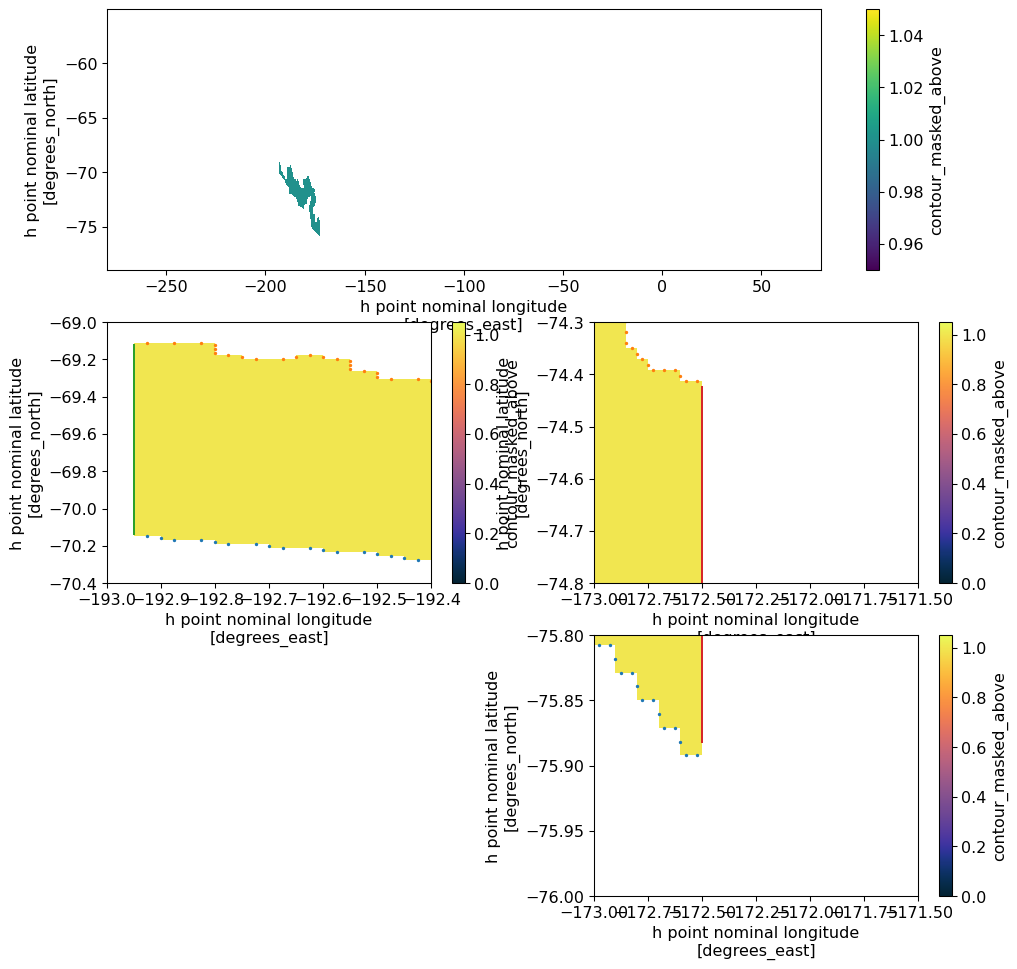

In [51]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
mask_shelf.plot()


plt.subplot(3, 2, 3)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-193, -192.4)
plt.ylim(-70.4, -69)


plt.subplot(3, 2, 4)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-173, -171.5)
plt.ylim(-74.8, -74.3)


plt.subplot(3, 2, 6)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-173, -171.5)
plt.ylim(-76, -75.8)


plt.show()

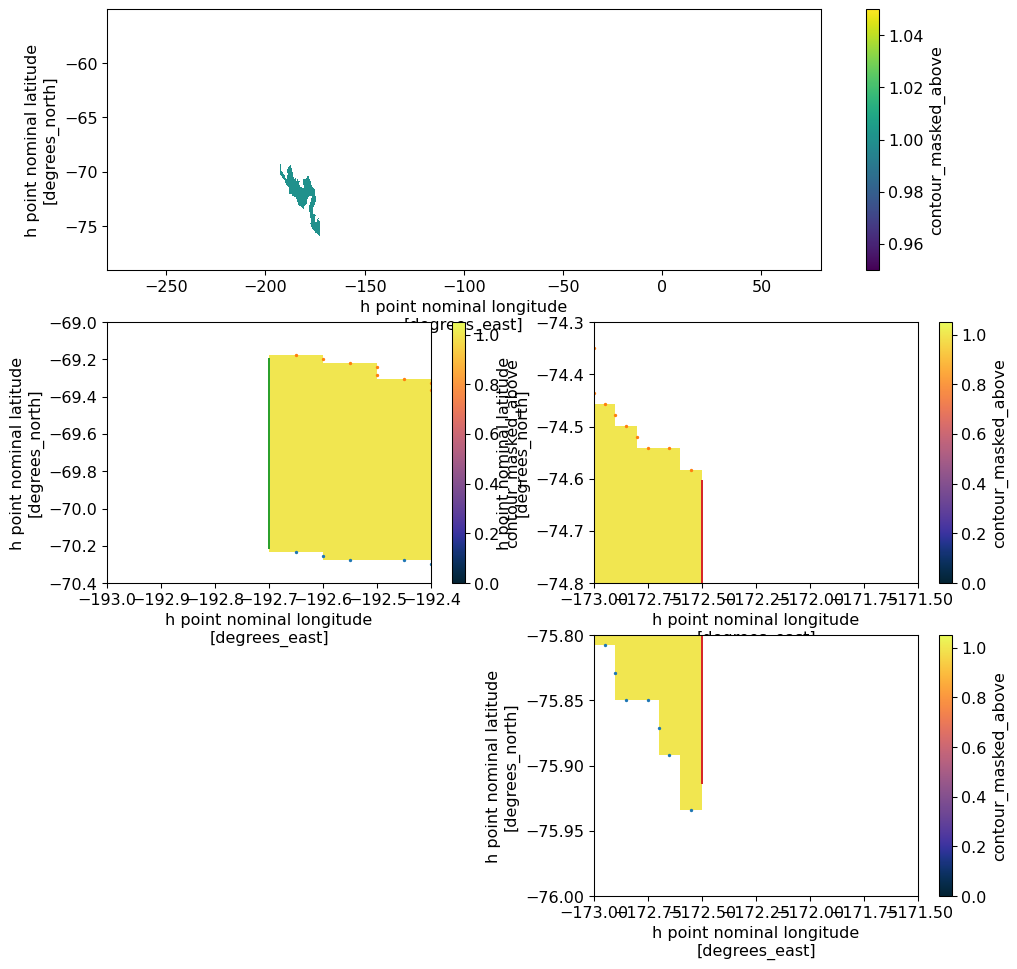

In [53]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
mask_shelf.plot()


plt.subplot(3, 2, 3)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-193, -192.4)
plt.ylim(-70.4, -69)


plt.subplot(3, 2, 4)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-173, -171.5)
plt.ylim(-74.8, -74.3)


plt.subplot(3, 2, 6)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-173, -171.5)
plt.ylim(-76, -75.8)


plt.show()

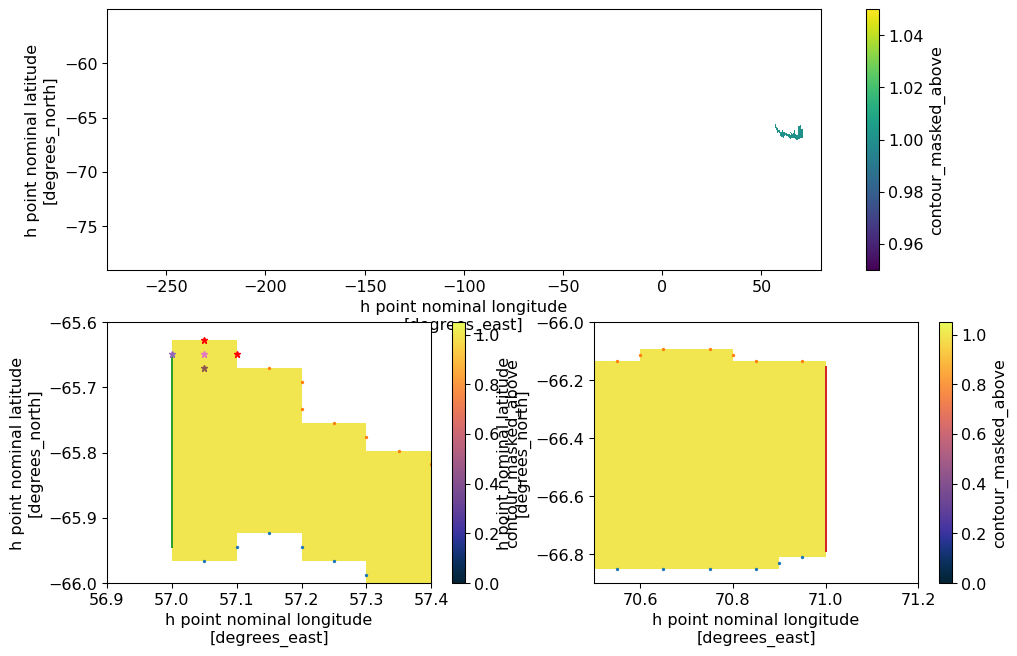

In [176]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
mask_shelf.plot()

plt.subplot(3, 2, 3)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

# plt.plot(iso2500.lon[:3:2], iso2500.lat[:3:2], '*', markersize=5)
plt.plot(U_min.xq, U_min.yh[-1], '*', markersize=5) 
plt.plot(V.xh.sel(xh=iso2500.lon[0]), V.yq.sel(yq=iso2500.lat[1]), '*', markersize=5)
plt.plot(mask_shelf.xh.sel(xh=iso2500.lon[0]), mask_shelf.yh.sel(yh=iso2500.lat[2]),
         '*', markersize=5)

plt.plot(V.xh.sel(xh=iso2500.lon[0]), V.yq.sel(yq=iso2500.lat[1]+.05, method='nearest'),
         'r*', markersize=5)
plt.plot(U.xq.sel(xq=iso2500.lon[2]), U.yh.sel(yh=iso2500.lat[2]),
         'r*', markersize=5)

plt.xlim(56.9, 57.4)
plt.ylim(-66, -65.6)


plt.subplot(3, 2, 4)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(70.5, 71.2)
plt.ylim(-66.9, -66)


plt.show()

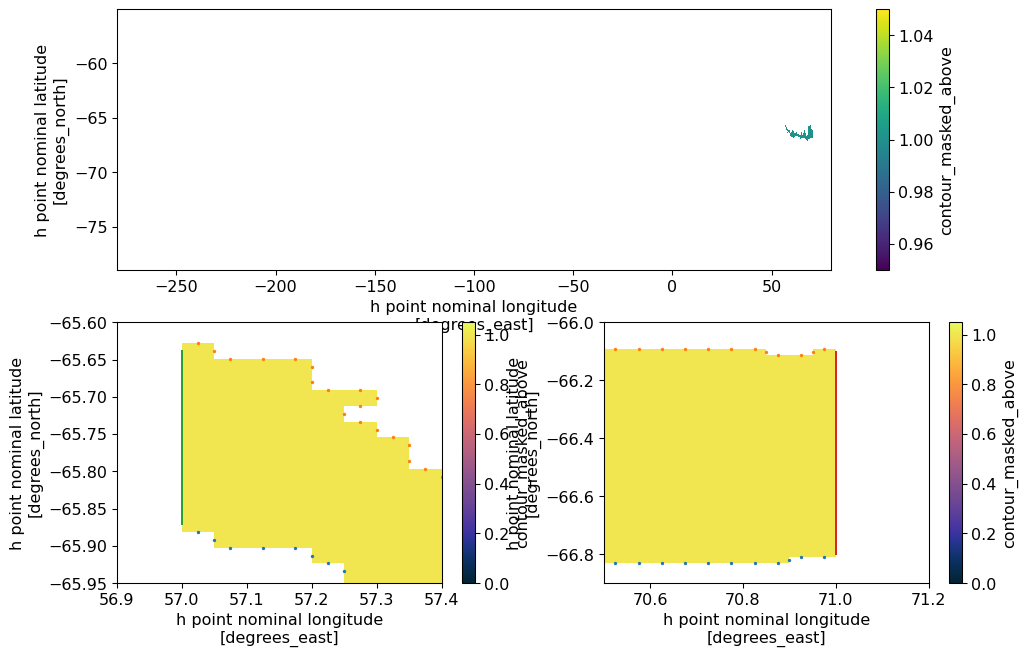

In [124]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
mask_shelf.plot()

plt.subplot(3, 2, 3)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(56.9, 57.4)
plt.ylim(-66, -65.6)


plt.subplot(3, 2, 4)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(70.5, 71.2)
plt.ylim(-66.9, -66)


plt.show()

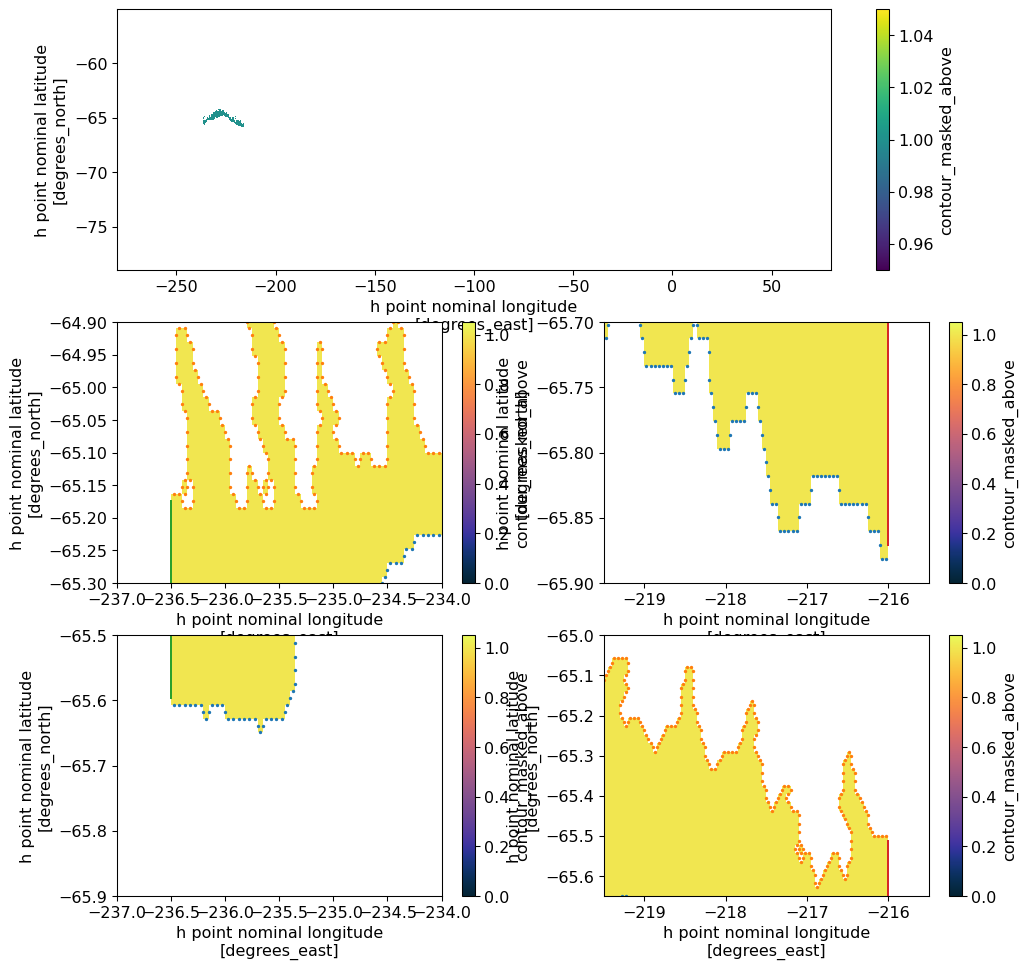

In [100]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
mask_shelf.plot()


plt.subplot(3, 2, 3)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-237, -234)
plt.ylim(-65.3, -64.9)


plt.subplot(3, 2, 4)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-219.5, -215.5)
plt.ylim(-65.9, -65.7)


plt.subplot(3, 2, 5)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-237, -234)
plt.ylim(-65.9, -65.5)


plt.subplot(3, 2, 6)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-219.5, -215.5)
plt.ylim(-65.65, -65)
plt.show()

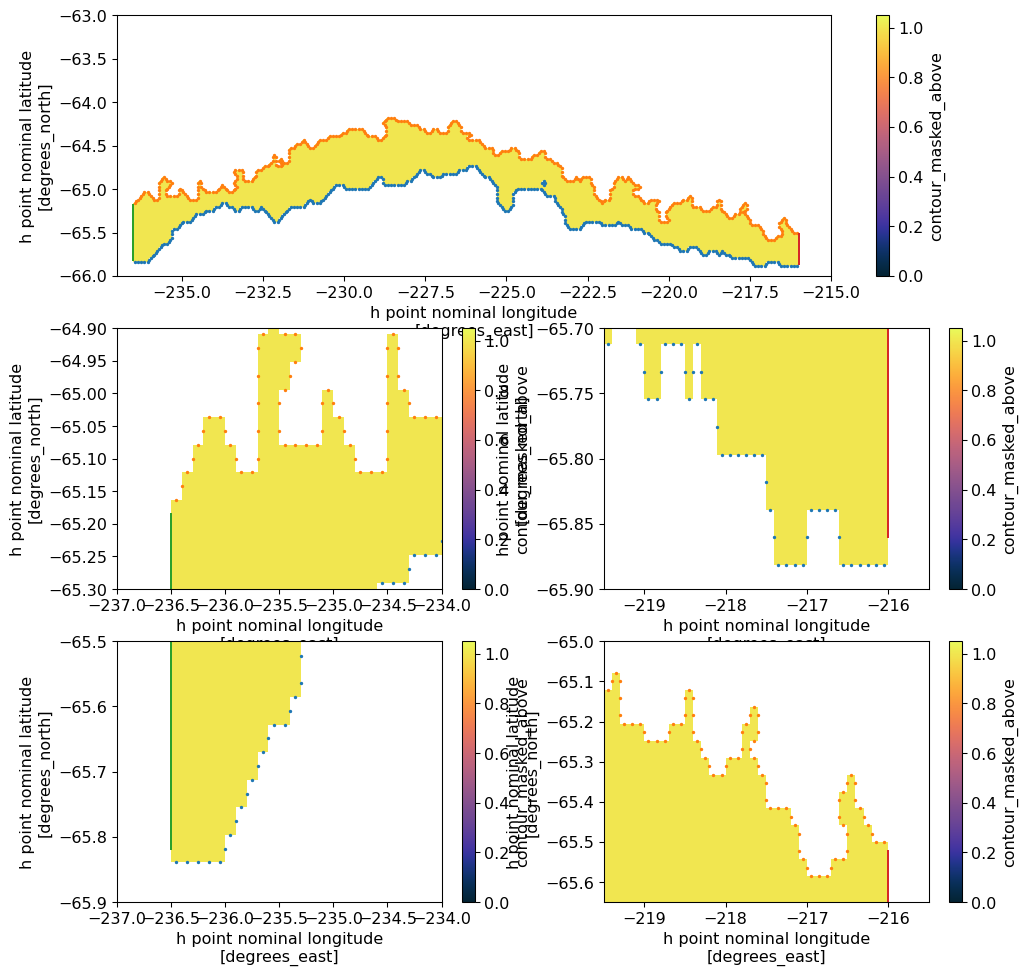

In [318]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)
plt.xlim(-237, -215)
plt.ylim(-66, -63)

plt.subplot(3, 2, 3)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-237, -234)
plt.ylim(-65.3, -64.9)


plt.subplot(3, 2, 4)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-219.5, -215.5)
plt.ylim(-65.9, -65.7)


plt.subplot(3, 2, 5)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-237, -234)
plt.ylim(-65.9, -65.5)


plt.subplot(3, 2, 6)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(np.tile(U_min.xq, len(U_min.yh)), U_min.yh) 
plt.plot(np.tile(U_max.xq, len(U_max.yh)), U_max.yh) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-219.5, -215.5)
plt.ylim(-65.65, -65)
plt.show()

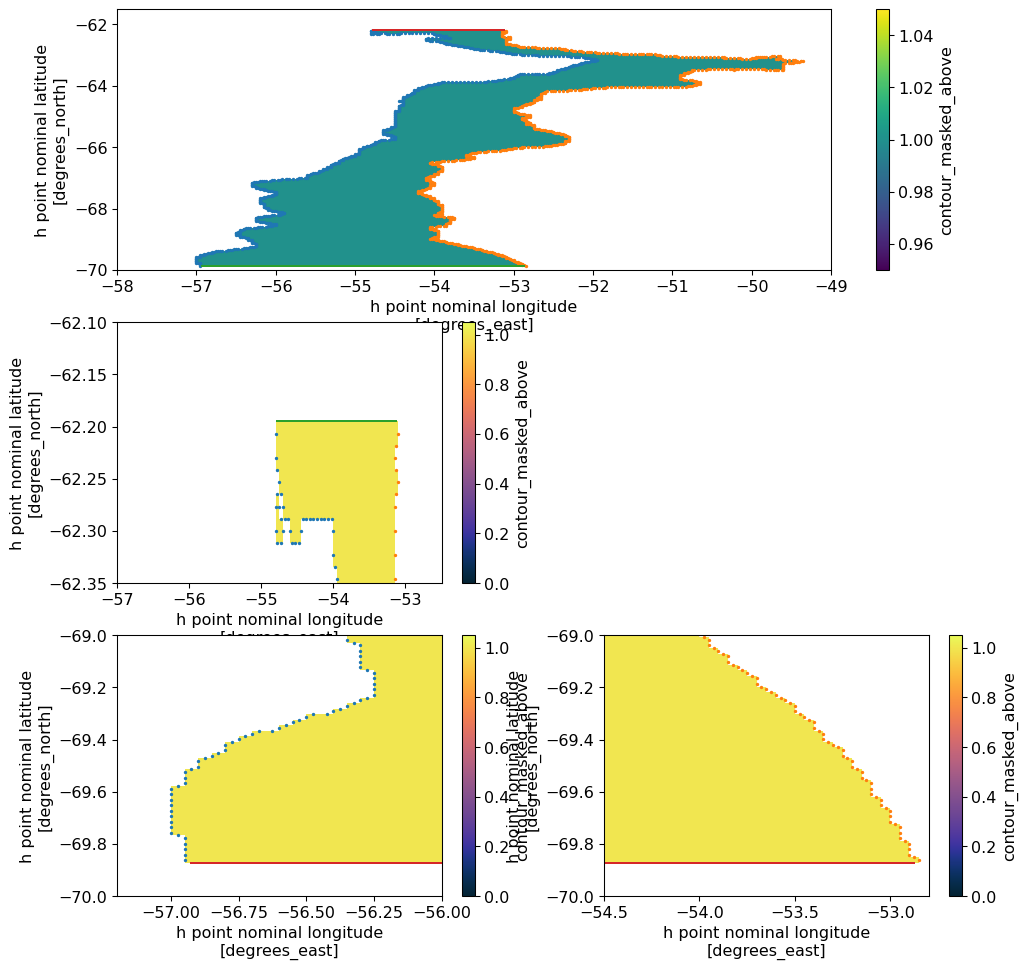

In [310]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
mask_shelf.plot()
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(V_min.xh, np.tile(V_min.yq, len(V_min.xh))) 
plt.plot(V_max.xh, np.tile(V_max.yq, len(V_max.xh))) 
plt.xlim(-58, -49)
plt.ylim(-70, -61.5)


plt.subplot(3, 2, 3)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(V_max.xh, np.tile(V_max.yq, len(V_max.xh))) 
plt.plot(V_min.xh, np.tile(V_min.yq, len(V_min.xh))) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)


plt.xlim(-57, -52.5)
plt.ylim(-62.35, -62.1)


plt.subplot(3, 2, 5)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(V_max.xh, np.tile(V_max.yq, len(V_max.xh))) 
plt.plot(V_min.xh, np.tile(V_min.yq, len(V_min.xh))) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-57.2, -56)
plt.ylim(-70, -69)

plt.subplot(3, 2, 6)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(V_max.xh, np.tile(V_max.yq, len(V_max.xh))) 
plt.plot(V_min.xh, np.tile(V_min.yq, len(V_min.xh))) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-54.5, -52.8)
plt.ylim(-70, -69)

plt.show()

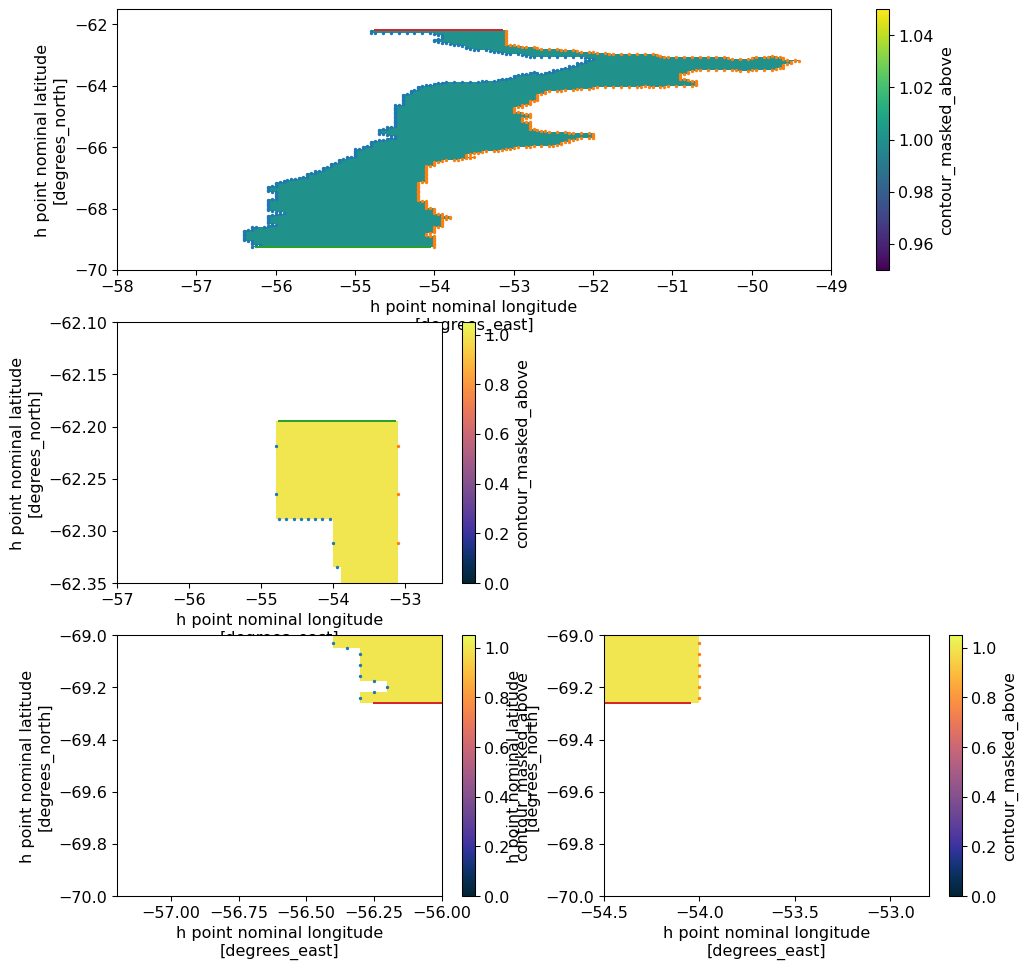

In [313]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
mask_shelf.plot()
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(V_min.xh, np.tile(V_min.yq, len(V_min.xh))) 
plt.plot(V_max.xh, np.tile(V_max.yq, len(V_max.xh))) 
plt.xlim(-58, -49)
plt.ylim(-70, -61.5)


plt.subplot(3, 2, 3)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(V_max.xh, np.tile(V_max.yq, len(V_max.xh))) 
plt.plot(V_min.xh, np.tile(V_min.yq, len(V_min.xh))) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)


plt.xlim(-57, -52.5)
plt.ylim(-62.35, -62.1)


plt.subplot(3, 2, 5)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(V_max.xh, np.tile(V_max.yq, len(V_max.xh))) 
plt.plot(V_min.xh, np.tile(V_min.yq, len(V_min.xh))) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-57.2, -56)
plt.ylim(-70, -69)

plt.subplot(3, 2, 6)
plt.plot(iso650.lon, iso650.lat, '.')
plt.plot(iso2500.lon, iso2500.lat, '.')
plt.plot(V_max.xh, np.tile(V_max.yq, len(V_max.xh))) 
plt.plot(V_min.xh, np.tile(V_min.yq, len(V_min.xh))) 
mask_shelf.plot(cmap=cmo.thermal, vmin=0, vmax=1.05)

plt.xlim(-54.5, -52.8)
plt.ylim(-70, -69)

plt.show()